# Sentiment analysis of product reviews with Keras Tensorflow

**Project by**:
Yuliana Yakimchuk

### Table of Contents

* [Part 1. Exploratory Analysis and Data Preparation](#part1)
  * [Section 1.1 Exploratory Analysis](#section_1_1)
  * [Section 1.2 Data Cleaning](#section_1_2)
* [Part 2. Bidirectional LSTM](#part2)
* [Part 3. BERT](#part3)
* [Part 4. DistilBERT](#part4)
* [Part 5 DistilBERT without class weight](#part5)
* [Part 6 Conclusion](#part6)

### Dependencies

In [ ]:
# Utilities
import os
import json
import datetime

# Data munging
import pandas as pd
import numpy as np
np.random.seed(42)
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42) 

# Text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import transformers

import tensorflow_hub as hub
#!pip install tensorflow-text
import tensorflow_text as text
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertModel, DistilBertConfig


# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix

## Part 1 <a class="anchor" id="part1"></a>
### Data Exploration and Preparation

#### Section 1.1 <a class="anchor" id="section_1_1"></a>
Data retrieval and exploration

In [98]:
import pandas as pd
reviews_df = pd.read_json('Electronics_5.json', lines=True, nrows = 100000)
#the original file contains over 6 million reviews. For the sake of computational manageability, 
#we'll only work with 100K reviews

In [99]:
reviews_df.tail()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
99995,5,NaN,True,"05 17, 2015",A339O9NAO8SFRE,B000068P8W,{'Style:': ' Original'},Amazon Customer,excellent,Five Stars,1431820800,NaN
99996,5,NaN,True,"05 11, 2015",A3JEHUCCSYPVXQ,B000068P8W,{'Style:': ' Original'},paul ciborowski,This product is excellent I feel very safe usi...,Great Product Safe,1431302400,NaN
99997,5,NaN,True,"05 9, 2015",A1HQYGA37GTH55,B000068P8W,NaN,Nick,It does an excellent job of cleaning.,Five Stars,1431129600,NaN
99998,5,NaN,True,"04 29, 2015",A1VJWPJMCQN02J,B000068P8W,{'Style:': ' Original'},jc-6929,Very efficient,Five Stars,1430265600,NaN
99999,5,NaN,True,"04 13, 2015",A1QR1116WK6BZ6,B000068P8W,{'Style:': ' Original'},The Deacon,It cleans and provides good results. I am sat...,Five Stars,1428883200,NaN


In [100]:
reviews_df.info()
#we have lots of missing values in many categories, but we will only use reviewText and overall columns 
#for our sentiment analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         100000 non-null  int64 
 1   vote            17157 non-null   object
 2   verified        100000 non-null  bool  
 3   reviewTime      100000 non-null  object
 4   reviewerID      100000 non-null  object
 5   asin            100000 non-null  object
 6   style           61750 non-null   object
 7   reviewerName    99984 non-null   object
 8   reviewText      99986 non-null   object
 9   summary         99992 non-null   object
 10  unixReviewTime  100000 non-null  int64 
 11  image           1000 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 8.5+ MB


array([[<AxesSubplot:title={'center':'overall'}>]], dtype=object)

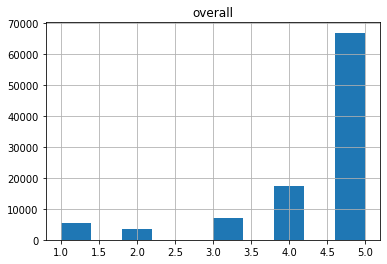

In [101]:
reviews_df.hist(column = 'overall')

#### Based on the above histogram, we can see that our dataset is heavily imbalanced, with the majority of reviews being positive, and only a small portion of negative reviews. We will have to address it when we train our model

#### Section 1.2 <a class="anchor" id="section_1_2"></a>
Data Cleaning

In [23]:
#first we should get rid of the features we will not be using for our analysis - i.e. everything except 'overall'
#and reviewText:
review_df = reviews_df[['overall','reviewText']]
review_df.tail()

,overall,reviewText
99995,5,excellent
99996,5,This product is excellent I feel very safe usi...
99997,5,It does an excellent job of cleaning.
99998,5,Very efficient
99999,5,It cleans and provides good results. I am sat...


In [24]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     100000 non-null  int64 
 1   reviewText  99986 non-null   object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [25]:
#we have some null values in review text, given the size of the dataset, we'll just remove these rows
review_df = review_df.dropna()
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99986 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     99986 non-null  int64 
 1   reviewText  99986 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [28]:
#for our usecase, we'll consider reviews with 1-3 stars as negative, and 4-5 stars as positive
review_df['rating']= review_df['overall'].map(lambda x: 0 if x in [1,2,3] else 1 )

In [29]:
review_df

,overall,reviewText,rating
0,5,This is the best novel I have read in 2 or 3 y...,1
1,3,"Pages and pages of introspection, in the style...",0
2,5,This is the kind of novel to read when you hav...,1
3,5,What gorgeous language! What an incredible wri...,1
4,3,I was taken in by reviews that compared this b...,0
...,...,...,...
99995,5,excellent,1
99996,5,This product is excellent I feel very safe usi...,1
99997,5,It does an excellent job of cleaning.,1
99998,5,Very efficient,1


In [ ]:
#we will save this prepped dataset to a .csv file in case we need to load it again
#review_df.to_csv('electronics_prepped.csv', index = False)
#review_df = pd.read_csv('electronics_prepped.csv')

In [30]:
review_df['rating'].value_counts(normalize = True)
#we have 84% major class, adn 16% minor class. When creating a model, we can expect 84% accuracy 
#for a model that only predicts the major class

1    0.843038
0    0.156962
Name: rating, dtype: float64

In [32]:
# We can drop the redundant "overall" feature now:
review_df = review_df.drop(columns = ['overall'])
review_df.head()

,reviewText,rating
0,This is the best novel I have read in 2 or 3 y...,1
1,"Pages and pages of introspection, in the style...",0
2,This is the kind of novel to read when you hav...,1
3,What gorgeous language! What an incredible wri...,1
4,I was taken in by reviews that compared this b...,0


## Part 2 <a class="anchor" id="part2"></a>
### Bidirectional LSTM

In [ ]:
#creating a multi-step NLP preprocessor for the base model
class Preprocessor():
     
    def __init__(self):
        return None
    
    def remove_special(self, sequence): #remove special characters and punctuation,excluding spaces
        import re
        import string
        sequence = re.sub(r'[^A-Za-z0-9\s]a', "", sequence)
        sequence = sequence.translate(str.maketrans('','',string.punctuation))
        return sequence
    
    def tokenize_lemmatize(self,sequence): #tokenize and lemmatize sequences
        from nltk import word_tokenize          
        from nltk.stem import WordNetLemmatizer
        from nltk.corpus import stopwords
        
        tokens = word_tokenize(sequence.lower())
        lemmatizer = WordNetLemmatizer()
        stop_words = set([word for word in stopwords.words("english") if word not in ['no','not']]) 
        #we don't want to remove negative words as they are important for understanding sentiment
        
        sequence = str()
        for word in tokens:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word)
                sequence += f" {word}"
        return sequence
    
    def __call__(self,sequence):   
        sequence = self.remove_special(sequence)
        sequence = self.tokenize_lemmatize(sequence)
        return sequence

In [34]:
#instantiate our class
inst = Preprocessor()

In [116]:
#try the functions on a subset of the original data as the process is computationally heavy
copy=review_df[:10]
copy

,reviewText,rating
0,This is the best novel I have read in 2 or 3 y...,1
1,"Pages and pages of introspection, in the style...",0
2,This is the kind of novel to read when you hav...,1
3,What gorgeous language! What an incredible wri...,1
4,I was taken in by reviews that compared this b...,0
5,I read this probably 50 years ago in my youth ...,1
6,I read every Perry mason book voraciously. Fin...,1
7,I love this series of Bertha and Lamb.. Great...,1
8,Great read!,1
9,"Crows Can't Count, A.A. Fair\n\nMr. Harry Shar...",1


In [117]:
copy['reviewText']=copy['reviewText'].apply(inst)

C:\Users\VR\AppData\Local\Temp\ipykernel_6164\1003064821.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['reviewText']=copy['reviewText'].apply(inst)


In [118]:
copy.head()
#seems like preprocessing worked well, we can apply changes to the whole df now

,reviewText,rating
0,best novel read 2 3 year everything fiction b...,1
1,page page introspection style writer like hen...,0
2,kind novel read time lose book day possibly w...,1
3,gorgeous language incredible writer last life...,1
4,taken review compared book leopard promised b...,0


In [38]:
df_LSTM = review_df

In [39]:
df_LSTM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99986 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  99986 non-null  object
 1   rating      99986 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
#df_LSTM['reviewText'] = df_LSTM['reviewText'].apply(inst)

In [40]:
#for saving computational resources if need to rerun notebook
#df_LSTM.to_csv('df_LSTM_preprocessed.csv', index = False)
df_LSTM = pd.read_csv('df_LSTM_preprocessed.csv')

In [41]:
df_LSTM.head()

,reviewText,rating
0,best novel read 2 3 year everything fiction b...,1
1,page page introspection style writer like hen...,0
2,kind novel read time lose book day possibly w...,1
3,gorgeous language incredible writer last life...,1
4,taken review compared book leopard promised b...,0


In [42]:
#calculate class weights
class_total = dict(df_LSTM['rating'].value_counts())
class_total

{1: 84292, 0: 15694}

In [43]:
total = 0
for value in class_total.values():
    total+=value

class_weights={}
for key in class_total.keys():
    class_weight = total/(2*class_total[key])
    class_weights[key] = class_weight

class_weights

{1: 0.5930930574669008, 0: 3.1854848986873963}

In [44]:
df_LSTM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99986 entries, 0 to 99985
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  99820 non-null  object
 1   rating      99986 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [45]:
df_LSTM.dropna(inplace = True)
df_LSTM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99820 entries, 0 to 99985
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  99820 non-null  object
 1   rating      99820 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [46]:
#we'll use startified split as our data is imbalanced
X_train,X_test,y_train, y_test = train_test_split(df_LSTM['reviewText'], df_LSTM['rating'], 
                                                  test_size = 0.2, random_state = 42, stratify = df_LSTM['rating'])

In [47]:
X_test

36757     great polarizer much expensive polarizer anot...
8438                nice surge protector use plug computer
69650                 working good nice sound easy install
56331     wonder winder work great three shop first one...
11414     shipping quick packaging adequate product loc...
                               ...                        
86322     cant get excited cable decent quality work 20...
35465     get job done bracelet not stretchy expecting ...
71769     extremely compact easy use may need something...
92240     4th digital camera certainly improved chose 7...
14611     excellent sound comfortable fit great quality...
Name: reviewText, Length: 19964, dtype: object

In [49]:
max_len = 200
tokenizer = Tokenizer(num_words=max_len, split=' ', lower = False) #well keep up to 200 words per review
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

In [50]:
vocab_size

63696

In [51]:
#LSTM requires all inputs to be the same size. Since some reviews are smaller than 200 words, we need to pad 
#them to 200
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_len)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = max_len)
X_train_padded.shape

(79856, 200)

In [53]:
X_train_padded
#we can see lots of zeroes at teh beginnings of sequences, meaning padding worked

array([[  0,   0,   0, ...,  49, 106,  92],
       [  0,   0,   0, ...,   0, 194,  52],
       [  0,   0,   0, ...,  38,   5, 147],
       ...,
       [  0,   0,   0, ...,  13, 185,  88],
       [  0,   0,   0, ...,  80,  79,   8],
       [  0,   0,   0, ...,   7,  96,  44]])

In [52]:
#we'll use a bidirectional LSTM model as our baseline. LSTM because it can remember longer sequences than RNN. 
#Bidirectional as it can use future context, which ultimately leads to better performance on NLP tasks.
#the following architecture was chosen after some hyperparameter tuning as a balance bw performance, 
#generalization and and computation. Dropout added to combat overfitting. The word embedding of 128 dimensions 
#should give us a reasonably meaningful word representations without being too intense computationally.

base_model = Sequential([
    Embedding(input_dim=vocab_size,output_dim = 128, input_length = max_len),
    Bidirectional(LSTM(200, return_sequences=True, dropout = 0.2)), 
    Bidirectional(LSTM(100, dropout = 0.2)),
    Dense(1, activation='sigmoid')
])

In [54]:
base_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [55]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          8153088   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 400)         526400    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              400800    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 9,080,489
Trainable params: 9,080,489
Non-trainable params: 0
_________________________________________________________________


In [56]:
batch_size = 64
checkpoint_cb = ModelCheckpoint("LSTM_model.h5", save_best_only = True)
early_stop_cb = EarlyStopping(patience = 10, restore_best_weights = True)

In [ ]:
#optional resetting of model weights for hyperparameter tuning
def reset_weights(model,initializer = keras.initializers.he_normal):
    initial_weights = model.get_weights()
    new_weights = [(initializer()(w.shape)) for w in initial_weights]
    model.set_weights(new_weights)
#reset_weights(model)

LSTM_hist = base_model.fit(X_train_padded, y_train, validation_split = 0.2, 
                      batch_size = batch_size, class_weight = class_weights,
                      callbacks = [tensorboard_cb, checkpoint_cb, early_stop_cb], epochs = 100)

In [57]:
#optional load model if notebook needs to be rerun

base_model = keras.models.load_model("LSTM_model.h5")

In [58]:
base_model.evaluate(X_test_padded, y_test)

624/624 [==============================] - 17s 23ms/step - loss: 0.4350 - accuracy: 0.7979


[0.4350122809410095, 0.7978861927986145]

In [59]:
y_prob = base_model.predict(X_test_padded)
y_pred = np.round(y_prob)

624/624 [==============================] - 14s 21ms/step


In [60]:
print(classification_report(y_pred,y_test, digits = 2))

              precision    recall  f1-score   support

         0.0       0.72      0.42      0.53      5437
         1.0       0.81      0.94      0.87     14527

    accuracy                           0.80     19964
   macro avg       0.77      0.68      0.70     19964
weighted avg       0.79      0.80      0.78     19964



Text(33.0, 0.5, 'Predicted Output')

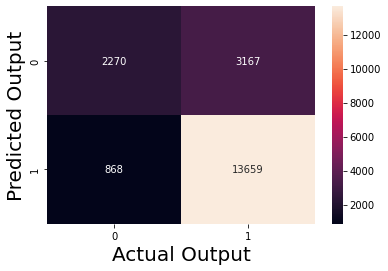

In [61]:
cm= confusion_matrix(y_pred, y_test)
ax=sns.heatmap(cm, annot=True, fmt="0", annot_kws={"size":10})
plt.xlabel('Actual Output', fontsize=20)
plt.ylabel('Predicted Output', fontsize=20)

#### As is usually the case, our model performs better on the major class, but it still has predictive value for the minor class. In fact, precision is not terrible. Though recall could be better. We'll try to see the kinds of reviews it's struggling with

In [62]:
ground_truth = np.expand_dims(np.array(y_test),axis = 1)

In [63]:
ground_truth.shape

(19964, 1)

In [64]:
indices = [i for i,v in enumerate(y_pred) if y_pred[i]!=ground_truth[i]]
correct_label =[ground_truth[i][0] for i in indices]
wrong_pred = [X_test_padded[i] for i in indices]
wrong_pred = tokenizer.sequences_to_texts(wrong_pred)
wrong_pred_labeled = list(zip(correct_label,wrong_pred))
wrong_pred_labeled

[(0, 'working good nice sound easy'),
 (1,
  'product cable good quality work purchased used item look new cost new one much like take always good used item amazon problem back'),
 (0, 'get clear good perfect fit lot people lot light im'),
 (1,
  'set headphone use monitor sound dont get since price right bass not high right also cable plug quite price good buy ear quite comfortable dont last far great no get'),
 (1,
  'item read review first also good review think going first no dont know not go way case case work made sure way put case back'),
 (1, 'screen work better screen much better image monitor'),
 (0,
  'made purchase could used another work fine no problem dont like need product'),
 (1, 'case'),
 (1,
  'got best buy problem get little ive month not bad thing high review first time using not problem even issue not issue problem new doesnt needed get great bad say also look'),
 (1, 'good quality make would use light'),
 (0, 'switch work say plug say nice switch price'),
 (1, 'f

#### While the preprocessed texts are not always easy to interpret, we do see in some instances negative words are used in an overall positive review and the other way around, and even for a human to interpret these reviews as negative or positive would be challenging. We should also keep in mind that reviews are highly subjective, and one person may be very upset over small defects, while another would be more forgiving, and this will be reflected in the final star rating

## Part 3 <a class="anchor" id="part3"></a>
### Transfer Learning with BERT

#### To improve on the results of an LSTM, we'll try using a BERT model on these texts. Bert has built-in preprocessing, and we do not need to use any additional data cleaning/transformation for it.

In [66]:
X_train,X_test, y_train, y_test = train_test_split(review_df['reviewText'], review_df['rating'],
                                                   test_size = 0.2, random_state = 42, 
                                                   stratify = review_df['rating'])
X_train

65360    I have to add my $.02.  This is a super little...
27108    great Radio, looking for a radio to just use i...
47686    I'll be honest, I don't know too much about UV...
88927                               Fast and Easy process!
39240    Just a nice thing that it's good to have for t...
                               ...                        
18638                           nothing else is important!
61808    I was looking for a lens to get low light port...
60955    Great little lens...I tend to leave it on my c...
48546                                              perfect
77601    Dear Self,\n\nEver since you bought these deli...
Name: reviewText, Length: 79988, dtype: object

In [67]:
X_test.shape

(19998,)

In [68]:
#we'll use keras hub that has the model  and preprocessor already configured
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [69]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers - we added additional dropout to combat overfitting and a 
#dense layer as initial model did not perform that well

top = tf.keras.layers.Dropout(0.3, name="dropout")(outputs['pooled_output'])
top = tf.keras.layers.Dense(100)(top)
top = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(top)

bert_model = tf.keras.Model(inputs=[text_input], outputs = [top])


In [70]:
bert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
#As we can see, only layers added by us are trainable

checkpoint_cb = ModelCheckpoint("bert.h5", save_best_only = True)
bert_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bert_model.fit(X_train, y_train, validation_split = 0.2, epochs=100, batch_size = 64,class_weight = class_weights,
                      callbacks = [checkpoint_cb, early_stop_cb],)

In [72]:
#optional loading saved model if we need to rerun notebook. Since it contains a keras hub custom layer, 
#we need to pass custom objects
bert_model = keras.models.load_model("bert.h5",
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [77]:
start_time = datetime.datetime.now()

bert_model.evaluate(X_test, y_test)

end_time = datetime.datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(time_diff,execution_time)

625/625 [==============================] - 282s 451ms/step - loss: 0.3652 - accuracy: 0.8591
0:04:42.445603 282445.603


In [74]:
y_proba = bert_model.predict(X_test)
y_pred_bert = np.round(y_proba)

625/625 [==============================] - 281s 449ms/step


In [75]:
print(classification_report(y_pred_bert,y_test, digits = 2))

              precision    recall  f1-score   support

         0.0       0.40      0.57      0.47      2208
         1.0       0.94      0.89      0.92     17790

    accuracy                           0.86     19998
   macro avg       0.67      0.73      0.70     19998
weighted avg       0.88      0.86      0.87     19998



Text(33.0, 0.5, 'Predicted Output')

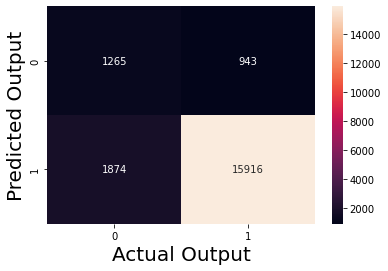

In [76]:
cm= confusion_matrix(y_pred_bert, y_test)
ax=sns.heatmap(cm, annot=True, fmt="0", annot_kws={"size":10})
plt.xlabel('Actual Output', fontsize=20)
plt.ylabel('Predicted Output', fontsize=20)

#### BERT gave us  a boost in performance,  and a better balance between precision and recall on the minor class, but it was very computationally heavy despite having been pretrained. To try and mitigate these issues, we are going to try a Distilbert model - which is a smaller version of BERT that has significantly less parameters but preserves 95% of performance

## Part 4 <a class="anchor" id="part4"></a>
### Transfer Learning with DistilBERT

In [102]:
#We'll try another popular Deep Learning library - higging face. It has a number of pretrained transformer 
#architectures to choose from.
# Instantiate DistilBERT tokenizer...we use the Fast version due to computational limitations
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [103]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, 
                                                 random_state = 42, stratify = y_train)

In [104]:
'''
This function will prebatch and prepare data for distilbert model.
We will pass both the vectorized texts and attention mask to our model. Attention mask will allow the model 
to not waste resources on padded tokens. Also, the model requires to add beginning and end-of-sequence tokens 
to the inputs
We again limit texts to 200 words, 
'''
max_length = 200
def batch_encode(tokenizer, texts, batch_size=256, max_length=max_length):
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        count = 0
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,max_length=max_length,padding='max_length',
            truncation=True,return_attention_mask=True,return_token_type_ids=False)
                                             
    
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)
    
    
# Encode data:
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train.tolist())

X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_val.tolist())

X_test_ids, X_test_attention = batch_encode(tokenizer, X_test.tolist())

In [105]:
X_test_ids.shape

TensorShape([19998, 200])

In [ ]:
#We Will slightly change the default configuration to add Dropout for regularization purposes.
DISTILBERT_DROPOUT = 0.4
DISTILBERT_ATT_DROPOUT = 0.4

config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
                          attention_dropout=DISTILBERT_ATT_DROPOUT, 
                          output_hidden_states=True)

distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Make DistilBERT layers untrainable
for layer in distilBERT.layers:
    layer.trainable = False

In [107]:
'''
Function to build distilbert model
'''
MAX_LENGTH = 200
RANDOM_STATE = 42
def build_model(transformer, max_length=MAX_LENGTH):
    
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    cls_token = last_hidden_state[:, 0, :]

    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   #kernel_initializer=weight_initializer,  
                                   )(cls_token)
    
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    model.compile(tf.keras.optimizers.Adam(), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [108]:
distilbert = build_model(distilBERT, max_length = 200)

In [109]:
distilbert.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 200)]        0           []                               
                                                                                                  
 tf_distil_bert_model_3 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 200, 768),                                                   
                                 hidden_states=((No                                         

checkpoint_cb = ModelCheckpoint("distilbert.h5", save_best_only = True)
batch_size = 64
NUM_STEPS = len(X_train.index) //64
history = distilbert.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = 100,
    batch_size = 64,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], y_val.to_numpy()),
    class_weight = class_weights,
                      callbacks = [checkpoint_cb, early_stop_cb],
)

In [ ]:
distilbert = keras.models.load_model("distilbert.h5",
       custom_objects={'TFDistilBertModel':transformers.TFDistilBertModel}
)

In [111]:
start_time = datetime.datetime.now()

distilbert.evaluate([X_test_ids, X_test_attention], y_test)

end_time = datetime.datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(time_diff,execution_time) 
#the accuracy between BERT and DistilBERT is quite comparable, in fact DistilBERT is even slightly better on this run

625/625 [==============================] - 189s 300ms/step - loss: 0.3132 - accuracy: 0.8658
0:03:08.805296 188805.296


####  It would be hard to compare training time between Bert and DistilBert, since it runs through a different number of epochs, however at inference time, we can see that Bert takes 0:04:42 (4:42 minutes) to evaluate, and DistilBert needs 0:03:08 (3:08 minutes) for the same task. We can see computational savings at inference times.

In [112]:
y_proba_distil = distilbert.predict([X_test_ids, X_test_attention])
y_pred_distil = np.round(y_proba_distil)

625/625 [==============================] - 185s 294ms/step


In [113]:
print(classification_report(y_pred_distil,y_test, digits = 2))

              precision    recall  f1-score   support

         0.0       0.69      0.56      0.62      3863
         1.0       0.90      0.94      0.92     16135

    accuracy                           0.87     19998
   macro avg       0.79      0.75      0.77     19998
weighted avg       0.86      0.87      0.86     19998



#### DistilBERT seems to be doing better on our minor class - both in terms of precision and recall, but keeps good performance on the major class too

Text(33.0, 0.5, 'Predicted Output')

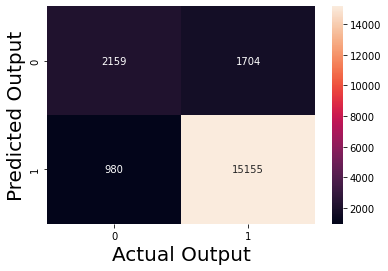

In [114]:
cm= confusion_matrix(y_pred_distil, y_test)
ax=sns.heatmap(cm, annot=True, fmt="0", annot_kws={"size":10})
plt.xlabel('Actual Output', fontsize=20)
plt.ylabel('Predicted Output', fontsize=20)

## Part 5 <a class="anchor" id="part5"></a>
### Transfer Learning with DistilBERT - this time no class weights

In [94]:
#for the sake of experiment, we want to see how running the model on an imbalanced dataset as is 
#will affect the final result
checkpoint_cb = ModelCheckpoint("distilbert_no_class_weight.h5", save_best_only = True)
batch_size = 64
NUM_STEPS = len(X_train.index) //64
history = distilbert.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = 100,
    batch_size = 64,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], y_val.to_numpy()),
                      callbacks = [checkpoint_cb, early_stop_cb],)

Epoch 1/100
874/874 [==============================] - 752s 860ms/step - loss: 0.3272 - accuracy: 0.8608 - val_loss: 0.2862 - val_accuracy: 0.8751
Epoch 2/100
874/874 [==============================] - 751s 860ms/step - loss: 0.3288 - accuracy: 0.8592 - val_loss: 0.2720 - val_accuracy: 0.8837
Epoch 3/100
874/874 [==============================] - 751s 860ms/step - loss: 0.3299 - accuracy: 0.8589 - val_loss: 0.2695 - val_accuracy: 0.8858
Epoch 4/100
874/874 [==============================] - 750s 859ms/step - loss: 0.3280 - accuracy: 0.8616 - val_loss: 0.2736 - val_accuracy: 0.8832
Epoch 5/100
874/874 [==============================] - 750s 859ms/step - loss: 0.3282 - accuracy: 0.8594 - val_loss: 0.2777 - val_accuracy: 0.8804
Epoch 6/100
874/874 [==============================] - 751s 859ms/step - loss: 0.3303 - accuracy: 0.8582 - val_loss: 0.2737 - val_accuracy: 0.8827
Epoch 7/100
874/874 [==============================] - 750s 859ms/step - loss: 0.3294 - accuracy: 0.8590 - val_loss: 0

In [95]:
distilbert.evaluate([X_test_ids, X_test_attention], y_test)

625/625 [==============================] - 185s 296ms/step - loss: 0.2699 - accuracy: 0.8852


[0.2699439227581024, 0.885238528251648]

In [96]:
y_proba_distil_no_weight = distilbert.predict([X_test_ids, X_test_attention])
y_pred_distil_no_weight = np.round(y_proba_distil)

625/625 [==============================] - 184s 294ms/step


In [97]:
print(classification_report(y_pred_distil_no_weight,y_test, digits = 2))

              precision    recall  f1-score   support

         0.0       0.01      0.15      0.02       265
         1.0       0.99      0.84      0.91     19733

    accuracy                           0.83     19998
   macro avg       0.50      0.50      0.47     19998
weighted avg       0.97      0.83      0.90     19998



#### As expected, we get very good performance on the major class, but model is pretty much useless for predicting the minor class, which demonstrated the importance of choosing correct metrics for evaluation and proper preparation of imbalanced datasets

## Part 6 <a class="anchor" id="part6"></a>
### Conclusion and Challenges

### Challenges: 
1. NLP is an active area of research and even state-of-the-art models often struggle on simple (in human terms) language tasks. 
2. Language models require large computational power and amounts of data, since the feature space is as a rule very large. 
3. NLP is also challenging in terms of data preparation. Different models require different input format, and even built-in preprocessors still ofteen require a lot of addiitonal steps. 
4. In terms of the specific dataset we chose - reviews are highly subjective and the same defects in the product can be calssified by reviewers as accceptable and overall positive or unacceptable and negative. We can think of such data as crowd-sourced data labeling. There are no experts, who can use objective criteria to determine if the text has positive or negative connotation. Every reviewer has their own assessment of the same product.

### In our project we investigated different model architectures for performing NLP sentiment analysis. We were able to achieve the best accuracy of ~86% with the best perorming model (DistilBERT), with an F1-score of 62 for the minor class. Our opinion is that further hyperparameter tuning and trying other architectures will further improve the performance of the model. In fact, even Bidirectional LSTM could be further improved and is much faster in terms of training than  transformers with transfer learning. 